a. Especificaciones de la serie

In [1]:
import pandas as pd
df_import = pd.read_excel("Importacion.xlsx")
df_import["Fecha"] = pd.to_datetime(df_import["Fecha"])


serie_super = df_import[["Fecha", "Gasolina superior"]].dropna()
serie_super.set_index("Fecha", inplace=True)


inicio = serie_super.index.min()
fin = serie_super.index.max()
frecuencia = pd.infer_freq(serie_super.index)
print(f"Inicio: {inicio}, Fin: {fin}, Frecuencia: {frecuencia}")

Inicio: 2001-01-01 00:00:00, Fin: 2024-12-01 00:00:00, Frecuencia: MS


La serie univariante de importación de gasolina superior tiene una frecuencia mensual (MS), inicia en enero de 2001 y finaliza en diciembre de 2024. Esto significa que se cuenta con datos mensuales de importación para cada mes en ese rango de fechas.

b. Gráfico de la serie

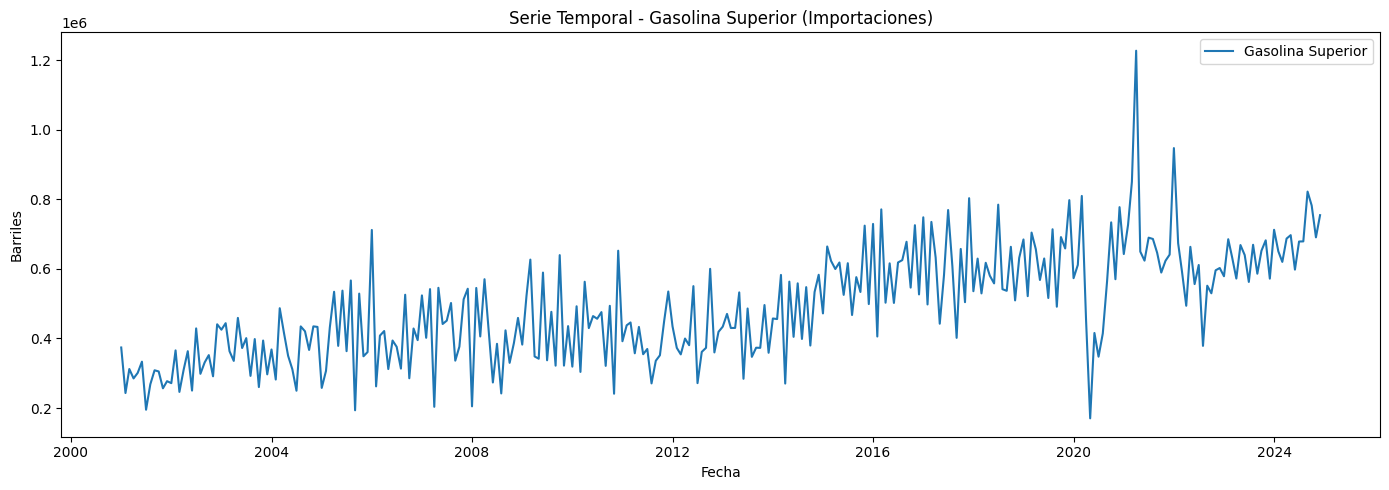

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))
plt.plot(serie_super, label="Gasolina Superior")
plt.title("Serie Temporal - Gasolina Superior (Importaciones)")
plt.ylabel("Barriles")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


Al observar el gráfico de la serie temporal de las importaciones de gasolina superior, se identifica una tendencia general al alza desde el año 2001 hasta 2024, lo que sugiere un aumento sostenido en la demanda o consumo de este combustible. A simple vista, se perciben fluctuaciones regulares que podrían estar relacionadas con patrones estacionales, así como una mayor variabilidad en los últimos años. Destaca un comportamiento atípico alrededor del año 2021, donde se presenta un pico abrupto de importación, posiblemente vinculado a efectos de la pandemia de COVID-19, ya sea por interrupciones en la cadena de suministro o por acumulación estratégica de reservas. En conjunto, la serie muestra una evolución con tendencia creciente, cierta estacionalidad y eventos excepcionales que rompen la regularidad del comportamiento mensual.

c. Descomposición en componentes

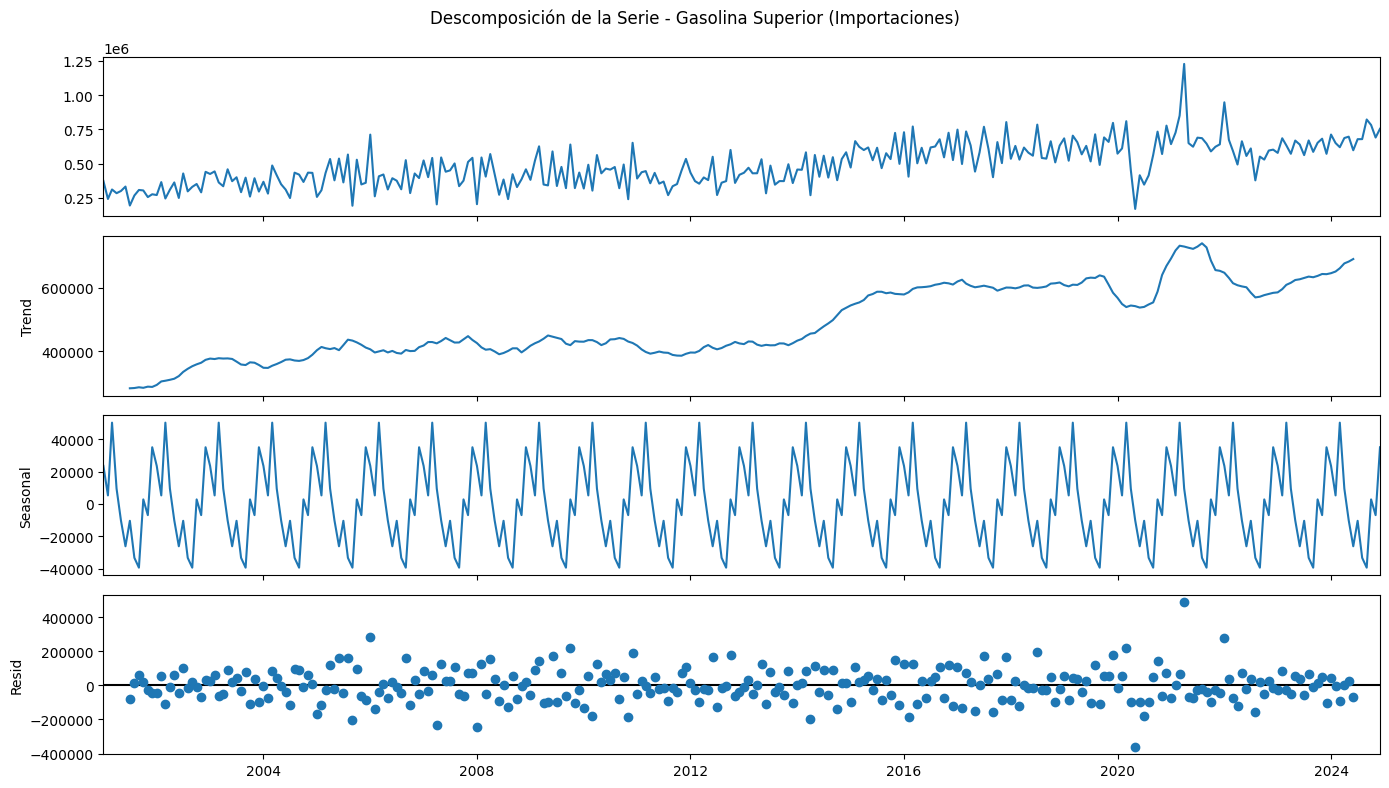

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie_super, model='additive', period=12)

fig = descomposicion.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Descomposición de la Serie - Gasolina Superior (Importaciones)")
plt.tight_layout()
plt.show()

Al descomponer la serie temporal de importaciones de gasolina superior en sus componentes, se observa claramente la presencia de una tendencia creciente a lo largo del tiempo, especialmente acentuada después de 2018. Esto indica que la serie no es estacionaria en media, ya que el valor promedio cambia sistemáticamente en el tiempo. 

En cuanto a la componente estacional, se aprecia un patrón cíclico que se repite cada año, lo que sugiere una estacionalidad consistente. 

Respecto a la varianza, aunque en general las fluctuaciones parecen mantenerse en un rango similar, hay periodos —como durante la pandemia— donde se observan aumentos importantes en la magnitud de las variaciones (en los residuos), lo que pone en duda la estacionariedad en varianza.

d. Determine si es necesario transformar la serie. Explique.

Dado que la serie presenta una tendencia creciente a lo largo del tiempo y una estacionalidad marcada, es necesario aplicar transformaciones para estabilizar la media y, posiblemente, la varianza.

Además, si la varianza no es constante, como podría sugerirse por los picos irregulares y los residuos dispersos en ciertos períodos, podría considerarse una transformación logarítmica antes de diferenciar.

e. Autocorrelación

<Figure size 1000x400 with 0 Axes>

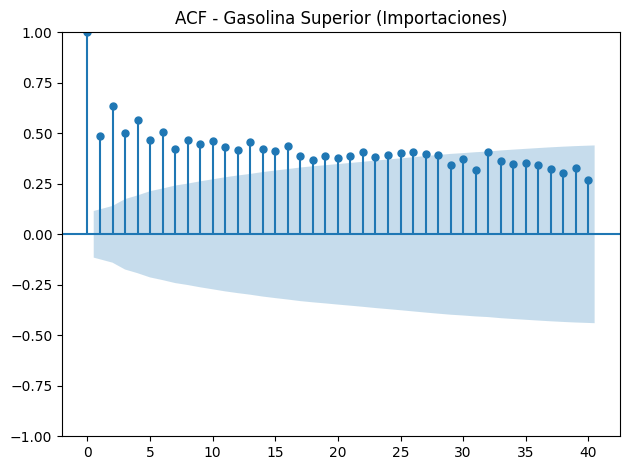

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(serie_super.dropna(), lags=40)
plt.title("ACF - Gasolina Superior (Importaciones)")
plt.tight_layout()
plt.show()


El gráfico de autocorrelación de la serie de importaciones de gasolina superior muestra una lenta disminución de los coeficientes, manteniéndose significativamente distintos de cero durante numerosos rezagos. Esta persistencia de la autocorrelación indica una fuerte dependencia temporal, lo cual es característico de una serie no estacionaria en media.

Por tanto, el comportamiento observado refuerza la necesidad de transformar la serie, para eliminar la tendencia y lograr estacionariedad en media.

 e.ii y la prueba de Dickey-Fuller aumentada (ADF)

In [8]:
from statsmodels.tsa.stattools import adfuller

# Serie original
serie = serie_super["Gasolina superior"]

# Prueba ADF
resultado_adf = adfuller(serie)
print("Resultado de la prueba Dickey-Fuller Aumentada (ADF):")
print(f"Estadístico ADF: {resultado_adf[0]}")
print(f"Valor p: {resultado_adf[1]}")
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"  {clave}: {valor}")


Resultado de la prueba Dickey-Fuller Aumentada (ADF):
Estadístico ADF: -1.6019866129262392
Valor p: 0.48259545408534815
Valores críticos:
  1%: -3.4540935579190495
  5%: -2.8719934111688965
  10%: -2.5723401594120388


Como el estadístico ADF (−1.602) es mayor que todos los valores críticos y el valor p (0.483) es significativamente mayor que 0.05, no se puede rechazar la hipótesis nula de que la serie tiene una raíz unitaria.
Esto indica que la serie no es estacionaria en media.

f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA
que utilizará para predecir. Explique en qué se basó para darle valor a estos
parámetros, basándose en las funciones de autocorrelación y autocorrelación
parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el
modelo propuesto.

Ya comprobamos anteriormente con la prueba ADF que la serie Gasolina superior (importaciones) no es estacionaria en media, pero sí lo es al aplicar una diferencia.

Por lo tanto, el valor de d = 1.

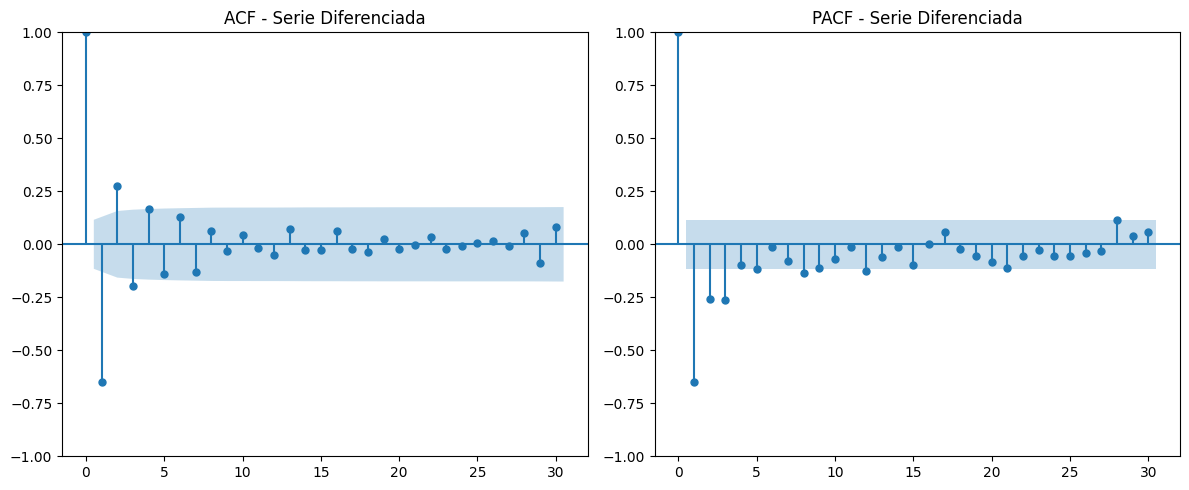

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(serie_diff, lags=30, ax=plt.gca())
plt.title("ACF - Serie Diferenciada")

plt.subplot(1, 2, 2)
plot_pacf(serie_diff, lags=30, ax=plt.gca(), method='ywm')  # 'ywm' es más estable que default
plt.title("PACF - Serie Diferenciada")

plt.tight_layout()
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Probar ARIMA(2,1,1) como ejemplo inicial
modelo = ARIMA(serie, order=(2, 1, 1))
resultado = modelo.fit()

print(resultado.summary())


C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

                               SARIMAX Results                                
Dep. Variable:      Gasolina superior   No. Observations:                  288
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3734.831
Date:                Wed, 16 Jul 2025   AIC                           7477.662
Time:                        20:44:00   BIC                           7492.300
Sample:                    01-01-2001   HQIC                          7483.529
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0728      0.063     -1.154      0.249      -0.197       0.051
ar.L2          0.2284      0.072      3.155      0.002       0.087       0.370
ma.L1         -0.9019      0.043    -21.137      0.0

Para determinar los parámetros del modelo ARIMA, se analizaron los gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) de la serie diferenciada. En el gráfico de ACF, se observa una caída rápida después del primer rezago, lo cual es indicativo de un componente de media móvil (MA) de orden 1. Por otro lado, el PACF muestra un corte después del segundo rezago, lo cual sugiere la presencia de un componente autorregresivo (AR) de orden 2. Dado que previamente se realizó una diferenciación para hacer la serie estacionaria, el valor de d es igual a 1.

Con base en este análisis, se propone un modelo ARIMA(2, 1, 1). Los resultados del ajuste del modelo muestran que los coeficientes para AR(2) y MA(1) son estadísticamente significativos (p < 0.05), lo cual respalda la validez del modelo. Además, los valores de AIC, BIC y HQIC son relativamente bajos, y la prueba de Ljung-Box indica que no hay autocorrelación significativa en los residuos (p = 0.74), lo cual sugiere un buen ajuste.

g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos
de la serie.

h. Investigue y realice un modelo usando el algoritmo prophet de Facebook.
Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?